### First own grid RL implementation

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [237]:
class environment():
    
    def __init__(self):
        self.final_state = None
        self.env = self.get_borderWorld()
        
    
    def get_step(self, state, action):
        "Actions: 0->Up, 1->Right, 2->Down, 3->Left"
        max_grid_size = self.env.shape[1]
        state_coordinates = np.array([int(state/max_grid_size), int(state%max_grid_size)])
        
        if action == 0:
            next_state_coordinates = state_coordinates + [-1, 0]
        if action == 1:
            next_state_coordinates = state_coordinates + [0, 1]
        if action == 2:
            next_state_coordinates = state_coordinates + [1, 0]
        if action == 3:
            next_state_coordinates = state_coordinates + [0, -1]
        
        next_state_coordinates = self.check_state(next_state_coordinates)
        
        reward = self.env[next_state_coordinates[0], next_state_coordinates[1]]
        
        next_state = next_state_coordinates[0] * max_grid_size + next_state_coordinates[1]
                                     
        return reward, next_state
    
    def get_n_states(self):
        return self.env.shape[0] * self.env.shape[1]
        
    
    def get_borderWorld(self):
        grid = np.zeros((5,5))
        grid[0,4] = 100
        self.final_state = 4
        grid[0:4,2] = -100
        
        return grid
    
    def check_state(self, state):
        # Check borders of grid (Stay on same position)
        if state[0] < 0:
            state[0] = 0
        if state[1] < 0:
            state[1] = 0
            
        max_size = self.env.shape
        if state[0] >= max_size[0]:
            state[0] = max_size[0]-1
        if state[1] >= max_size[1]:
            state[1] = max_size[1]-1
                                     
        return state
    
    def plot_grid(self, grid=None):
        if grid is None:
            grid = self.env
        fig, ax = plt.subplots()
        im = ax.imshow(grid)
        for i in range(grid.shape[0]):
            for j in range(grid.shape[0]):
                if i==0 and j==0:
                    ax.text(j, i, "Start", ha="center", va="center", color="w")
                else:
                    ax.text(j, i, round(grid[i, j], 1), ha="center", va="center", color="w")
        plt.title("Grid Rewards")
        fig.tight_layout()
        plt.show()

In [265]:
np.linspace(4,0, 5)

array([4., 3., 2., 1., 0.])

In [273]:
def quiver_plot(q_values):
    dim_x = dim_y = 5
    X, Y = np.meshgrid(np.arange(5), np.arange(5))
    X = X + np.ones_like(X) * 0.5
    Y = Y + np.ones_like(Y) * 0.5
    plt.xlim([0, dim_x])
    plt.ylim([0, dim_y])
    
    amax = np.reshape(q_values.argmax(axis=1), (dim_y,dim_x))
    amax = amax[::-1,:]
    U = np.zeros(X.shape)
    V = np.zeros(X.shape)

    V[amax==0] = 1
    U[amax==1] = 1
    V[amax==2] = -1
    U[amax==3] = -1

    plt.grid()
    X[1:5,2] = None
    X[4,4] = None

    plt.text(0.2, 4.5, 'Start',fontsize=10)
    plt.text(4.3, 4.3, 'Goal',fontsize=10)
    plt.text(2.3, 4.5, 'Cliff',fontsize=10)
    plt.text(2.3, 3.5, 'Cliff',fontsize=10)
    plt.text(2.3, 2.5, 'Cliff',fontsize=10)
    plt.text(2.3, 1.5, 'Cliff',fontsize=10)

    plt.quiver(X,Y, U, V)

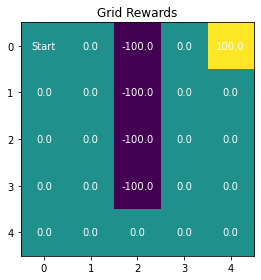

In [238]:
env = environment()
env.plot_grid()

In [285]:
def epsilon_greedy(values, epsilon = 0.2):
    """Action selection: epsilon greedy"""
    if np.max(values) == 0 or np.random.random() <= epsilon:
        return np.random.randint(len(values))
    else:
        return np.argmax(values)


In [174]:
def q_learning(q_values, state, action, reward, next_state, alpha, gamma):
    """Q-Value update"""
    q_sa = q_values[state, action]
    
    max_next_q = np.max(q_values[next_state])
    
    q_values[state, action] = q_sa + alpha * (reward + gamma * max_next_q - q_sa)
    
    return q_values

In [282]:
n_episodes = 1000

alpha = 0.1
gamma = 0.9

env = environment()
q_values = np.zeros((env.get_n_states(), 4))

for episode in range(n_episodes):
    state = 0

    while env.final_state != state:
        # Action selection
        action = epsilon_greedy(q_values[state])

        # Take action
        reward, next_state = env.get_step(state, action)

        # Update Table
        q_values = q_learning(q_values, state, action, reward, next_state, alpha, gamma)
        
        state = next_state


Actions: 0->Up, 1->Right, 2->Down, 3->Left

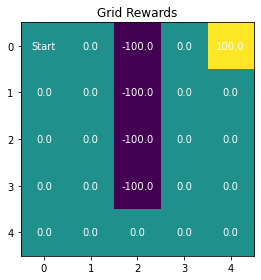

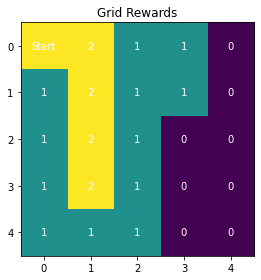

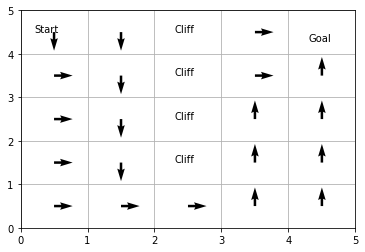

In [283]:
env = environment()
env.plot_grid()
env.plot_grid(q_values.argmax(axis=1).reshape(5,5))
quiver_plot(q_values)

##### With Upper Confidence Bound Sampling

In [297]:
def upper_confidence_bound(N_s, Q_s, t, c):
    if np.max(N_s) == 0:
        return np.random.randint(4)
    return np.argmax(Q_s + c * np.sqrt(np.log(t)/N_s))
    

In [300]:
n_episodes = 1000

alpha = 0.1
gamma = 0.9
c = 2

env = environment()
q_values = np.zeros((env.get_n_states(), 4))

N = np.ones(q_values.shape)
t = 0

for episode in range(n_episodes):
    state = 0

    while env.final_state != state:
        # Action selection
        action = upper_confidence_bound(N[state], q_values[state], t, c)
        N[state, action] += 1

        # Take action
        reward, next_state = env.get_step(state, action)

        # Update Table
        q_values = q_learning(q_values, state, action, reward, next_state, alpha, gamma)
        
        state = next_state
        t += 1


C:\Users\simon\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\simon\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


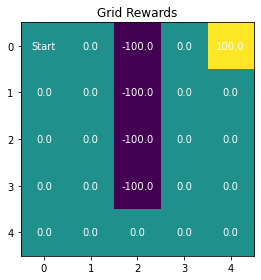

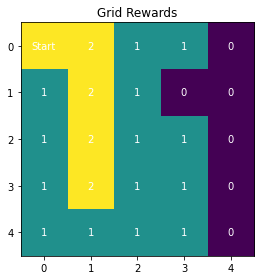

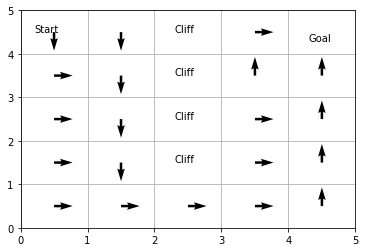

In [301]:
env.plot_grid()
env.plot_grid(q_values.argmax(axis=1).reshape(5,5))
quiver_plot(q_values)

### k armed bandit


In [330]:
def get_k_arms(k, runs=1000):
    arm_means = np.random.normal(0, size=k)
    # arm_rewards = np.random.normal(arm_means, size=(runs, k))
    # arm_rewards = arm_rewards.reshape(k, runs)
    return arm_means


In [400]:

n_runs = 100

alpha = 0.01
gamma = 0.9
c = 2

# Init bandit machine
k = 3
arm_means = get_k_arms(k)

q_values = np.zeros(k)
q_values_time = np.zeros((n_runs, k))

reward_values = np.zeros(n_runs)

N = np.ones(k)
for run in range(n_runs):
    # Action selection
    action = upper_confidence_bound(N, q_values, run, c)
    # N[state, action] += 1
    # action = epsilon_greedy(q_values, epsilon = 0.2)
    
    # Bandit
    reward = np.random.normal(arm_means[action])
    N[action] +=1
    reward_values[run] = reward
    
    # Update Table
    # q_values = q_learactionn)ing(q_values, state, action, reward, next_state, alpha, gamma)
    q_values[action] = q_values[action] + alpha * (reward - q_values[action]) # 1/N[action]
    
    q_values_time[run] = q_values_time[run-1]
    q_values_time[run, action] = q_values[action] + alpha * (reward - q_values[action]) # 1/N[action]



C:\Users\simon\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\simon\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


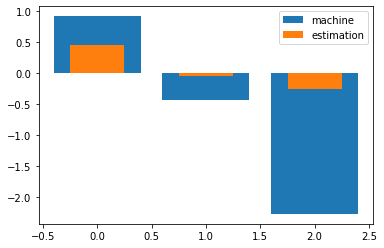

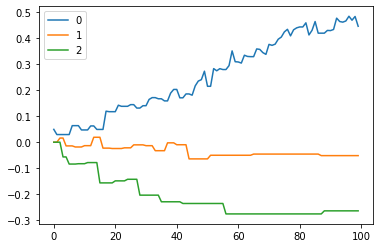

In [401]:
plt.bar(np.arange(k), arm_means, label="machine")
plt.bar(np.arange(k), q_values, label="estimation", width=0.5)
plt.legend()
plt.show()
plt.plot(q_values_time)
plt.legend(np.arange(k))